# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [64]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [65]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [66]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.head())
print(feat_info.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [67]:
# Identify missing or unknown data values and convert them to NaNs.
# print(azdias[azdias.isnull().values==True])
# azdias[azdias.isin(['unknown']).values==True]
azdias.describe()
# feat_info.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [68]:
print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [69]:
print(azdias['AGER_TYP'].value_counts())

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64


In [70]:
for i, info in feat_info.iterrows():
    for l in info['missing_or_unknown'].strip('[]').split(','):
        azdias[info['attribute']].replace(pd.to_numeric(l,errors='ignore'),np.nan, inplace=True)

In [71]:
print(azdias['AGER_TYP'].value_counts())

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [72]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
print(azdias.shape[0] - azdias.count())

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

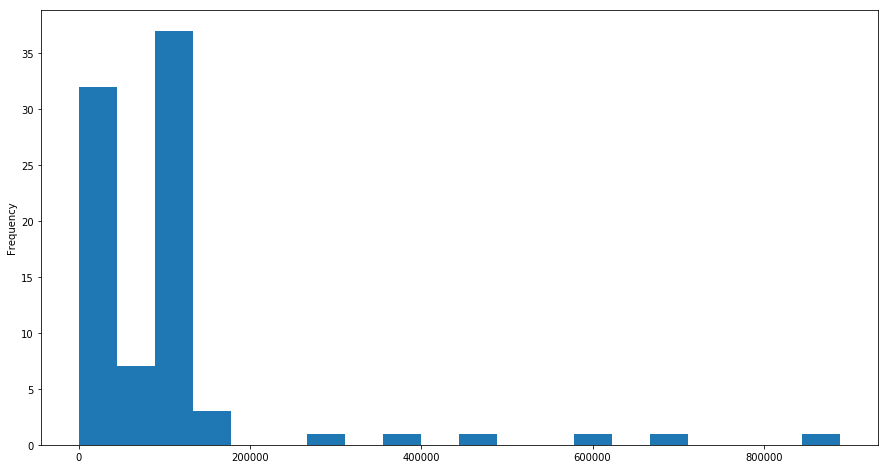

In [73]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(15,8)) 
(azdias.shape[0] - azdias.count()).plot.hist(bins=20)

In [74]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# remove columns which nan is more than 200000
my_azdias=azdias
my_feat_info=feat_info

for i in my_azdias:
    if (len(my_azdias[i]) - my_azdias[i].count())>200000:
        print(i)
        my_azdias.drop([i],axis=1,inplace=True)
        my_feat_info=my_feat_info[(~ my_feat_info['attribute'].str.contains(i))]
        

AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


In [75]:
print(my_feat_info)

                attribute information_level         type missing_or_unknown
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14          

In [76]:
my_azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)  
*I draw the plot about the missing data in each column.The missing data of most attributes is less than 200000，I remove the columns which is nan values more than 20000.*

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [77]:
print(len(my_azdias))

891221


In [78]:
# How much data is missing in each row of the dataset?
for t in range(76):
    threshold=75-t#
    print('threshold is ',threshold)
    print('not missing row is ',len(my_azdias.dropna(axis=0,how='any',thresh=threshold)))
    print('missing data row is ',len(my_azdias)-len(my_azdias.dropna(axis=0,how='any',thresh=threshold)))

threshold is  75
not missing row is  697109
missing data row is  194112
threshold is  74
not missing row is  719624
missing data row is  171597
threshold is  73
not missing row is  733395
missing data row is  157826
threshold is  72
not missing row is  747109
missing data row is  144112
threshold is  71
not missing row is  771701
missing data row is  119520
threshold is  70
not missing row is  774743
missing data row is  116478
threshold is  69
not missing row is  780153
missing data row is  111068
threshold is  68
not missing row is  781280
missing data row is  109941
threshold is  67
not missing row is  782046
missing data row is  109175
threshold is  66
not missing row is  785301
missing data row is  105920
threshold is  65
not missing row is  787544
missing data row is  103677
threshold is  64
not missing row is  792287
missing data row is  98934
threshold is  63
not missing row is  794792
missing data row is  96429
threshold is  62
not missing row is  795469
missing data row is  9

The threshold that I chosen is 65

In [79]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
nomiss_azdias=my_azdias.dropna(axis=0,how='any',thresh=65)
nomiss_azdias=nomiss_azdias.reset_index(drop = True)
miss_azidas=my_azdias.append(nomiss_azdias).drop_duplicates(keep=False)
miss_azidas=miss_azidas.reset_index(drop = True)
print('miss data row is ',len(miss_azidas),'not miss data row is ',len(nomiss_azdias))

miss data row is  47905 not miss data row is  787544


In [80]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
(my_azdias.shape[0] - my_azdias.count()).sort_values()

ZABEOTYP                      0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
GREEN_AVANTGARDE              0
SEMIO_PFLICHT                 0
FINANZTYP                     0
FINANZ_HAUSBAUER              0
FINANZ_UNAUFFAELLIGER         0
FINANZ_ANLEGER                0
FINANZ_VORSORGER              0
FINANZ_SPARER                 0
FINANZ_MINIMALIST             0
SEMIO_TRADV                   0
ANREDE_KZ                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
ALTERSKATEGORIE_GROB       2881
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
GFK_URLAUBERTYP            4854
                          ...  
ORTSGR_K

In [81]:
# Compare attribute 'ZABEOTYP','GFK_URLAUBERTYP','ANREDE_KZ','ALTERSKATEGORIE_GROB','LP_STATUS_GROB'
compare_list=['ZABEOTYP','GFK_URLAUBERTYP','ANREDE_KZ','ALTERSKATEGORIE_GROB','LP_STATUS_GROB']
print(miss_azidas[compare_list])

       ZABEOTYP  GFK_URLAUBERTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0             3             10.0          1                   2.0   
1             1              2.0          1                   3.0   
2             3             11.0          2                   3.0   
3             3              7.0          2                   2.0   
4             3              1.0          2                   NaN   
5             3              9.0          1                   2.0   
6             3              1.0          2                   3.0   
7             3             11.0          2                   3.0   
8             3              8.0          2                   3.0   
9             4              1.0          2                   1.0   
10            3             12.0          2                   2.0   
11            2              NaN          1                   3.0   
12            2              8.0          2                   2.0   
13            3              2.0  

In [82]:

def compare_dataset(attribute):
    df1=pd.DataFrame((miss_azidas[attribute].value_counts() / miss_azidas[attribute].count()).sort_index())
    df1['value']=df1.index
    
    df2=pd.DataFrame((nomiss_azdias[attribute].value_counts() / nomiss_azdias[attribute].count()).sort_index())
    df2['value']=df2.index
    # res = pd.concat([df1, df2], axis=0, ignore_index=True)
    # print(res)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.6)

    ax1=plt.subplot(211)
    plt.bar(df1['value'],df1[attribute])
    ax1.set_title('Missing dataset of '+attribute)
    ax1.set_xlabel('values')
    ax1.set_ylabel('the distribution of values')

    ax2=plt.subplot(212)
    plt.bar(df2['value'],df2[attribute])
    ax2.set_title('Not Missing dataset of '+attribute)
    ax2.set_xlabel('value')
    ax2.set_ylabel('the distribution of values')
    plt.show()

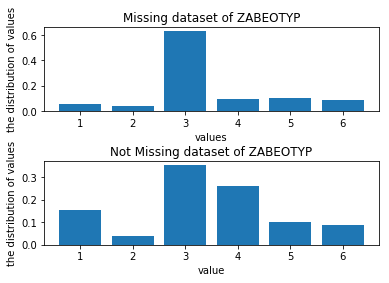

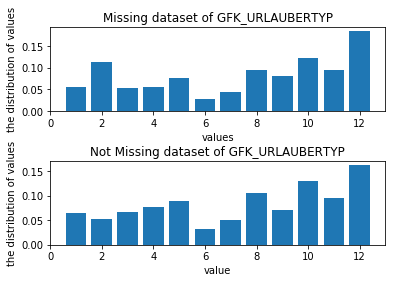

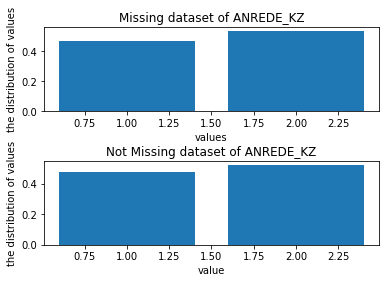

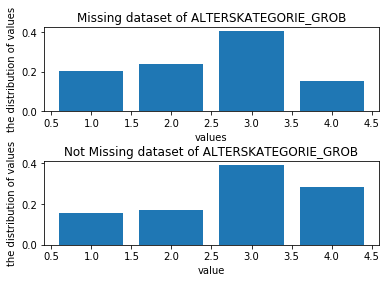

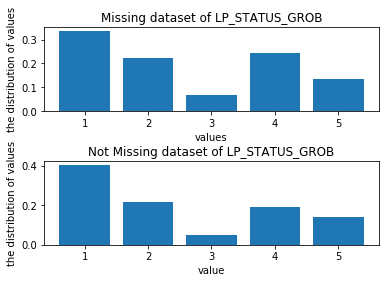

In [83]:
for l in compare_list:
    compare_dataset(l)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)  
*I found the different between missing dataset and not missing dataset with drawing the distribution plot that was acceptable.*

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [84]:
# How many features are there of each data type?
# print(nomiss_azdias.dtypes.value_counts())
print(my_feat_info['type'].value_counts())

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [85]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_list=[]
multi_list=[]
categorical_list=my_feat_info[my_feat_info['type']=='categorical']['attribute']
for i in categorical_list:
    n=nomiss_azdias[i].value_counts()
    if len(n)==2:
        binary_list.append(i)
    if len(n)>2:
        multi_list.append(i)
print('binary categorical: ',binary_list,'\n','multi-level categoricals: ',multi_list)

binary categorical:  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'] 
 multi-level categoricals:  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [86]:
# Re-encode categorical variable(s) to be kept in the analysis.
# binaray_list:
for i in binary_list:
    print(nomiss_azdias[i].value_counts())

2    410568
1    376976
Name: ANREDE_KZ, dtype: int64
0    614144
1    173400
Name: GREEN_AVANTGARDE, dtype: int64
0.0    780923
1.0      6621
Name: SOHO_KZ, dtype: int64
2.0    392287
1.0    359725
Name: VERS_TYP, dtype: int64
W    620787
O    166757
Name: OST_WEST_KZ, dtype: int64


In [87]:
# ANREDE_KZ
nomiss_azdias.loc[nomiss_azdias['ANREDE_KZ'] ==1,'ANREDE_KZ']=0
nomiss_azdias.loc[nomiss_azdias['ANREDE_KZ'] ==2,'ANREDE_KZ']=1
# # VERS_TYP
nomiss_azdias.loc[nomiss_azdias['VERS_TYP'] ==1.0,'VERS_TYP']=0
nomiss_azdias.loc[nomiss_azdias['VERS_TYP'] ==2.0,'VERS_TYP']=1
# # OST_WEST_KZ
nomiss_azdias.loc[nomiss_azdias['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
nomiss_azdias.loc[nomiss_azdias['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0

In [88]:
for i in binary_list:
    print(nomiss_azdias[i].value_counts())

1    410568
0    376976
Name: ANREDE_KZ, dtype: int64
0    614144
1    173400
Name: GREEN_AVANTGARDE, dtype: int64
0.0    780923
1.0      6621
Name: SOHO_KZ, dtype: int64
1.0    392287
0.0    359725
Name: VERS_TYP, dtype: int64
1    620787
0    166757
Name: OST_WEST_KZ, dtype: int64


In [89]:
# multi_list:
for i in multi_list:
    print(nomiss_azdias[i].value_counts())

4.0    195445
3.0    145030
2.0    140428
5.0    110108
6.0    100017
1.0     92221
Name: CJT_GESAMTTYP, dtype: int64
6    288034
1    194408
5    105447
2    103343
4     55468
3     40844
Name: FINANZTYP, dtype: int64
12.0    127379
10.0    101896
8.0      82378
11.0     74343
5.0      70195
4.0      60348
9.0      56240
3.0      53032
1.0      50415
2.0      41007
7.0      40382
6.0      25634
Name: GFK_URLAUBERTYP, dtype: int64
1.0     398081
10.0    127869
2.0      97036
11.0     48404
8.0      21506
7.0      19019
4.0      11395
5.0      11059
9.0      10348
6.0       8011
3.0       4485
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    398081
5.0    186621
2.0     97036
4.0     48536
3.0     26939
Name: LP_FAMILIE_GROB, dtype: int64
1.0     205688
9.0     133108
2.0     110468
10.0    110435
4.0      73636
3.0      68667
6.0      28481
5.0      26793
8.0      16864
7.0       9109
Name: LP_STATUS_FEIN, dtype: int64
1.0    316156
2.0    169096
4.0    149972
5.0    110435
3.0     37590
Na

In [90]:
azdias_multi_dummies=nomiss_azdias[multi_list]
azdias_multi_dummies=pd.get_dummies(azdias_multi_dummies)
azdias_data = pd.concat( [nomiss_azdias, azdias_multi_dummies], axis = 1 )

In [91]:
print(azdias_data.shape)
print(azdias_multi_dummies.shape)

(787544, 143)
(787544, 64)


In [92]:
azdias_data.drop(multi_list,axis=1,inplace=True)

In [93]:
azdias_data.shape

(787544, 119)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)  
*I chosen the categorical features with the type column of feat_info.I divided categorical into the binaray_list and multi_list with the value of the features which were chosen.For binaray_list I regularized the values of features,For multi_list I encoded the values using multiple dummy variables.*

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [94]:
my_feat_info[my_feat_info['type']=='mixed']
# print(nomiss_azdias[''])

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [95]:
azdias_data['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    180173
8.0     139934
10.0     84643
5.0      84134
3.0      53428
15.0     41635
11.0     35133
9.0      33474
6.0      25618
12.0     24196
1.0      20467
4.0      20423
2.0       7468
13.0      5658
7.0       3991
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [96]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
pj_pd=azdias_data[['PRAEGENDE_JUGENDJAHRE']]
pj_pd['PJ_DECADE']=np.nan
pj_pd['PJ_MOVEMENT']=0
# 40s
pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['1','2']),'PJ_DECADE']=1
pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['3','4']),'PJ_DECADE']=2
pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['5','6','7']),'PJ_DECADE']=3
pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['8','9']),'PJ_DECADE']=4
pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['10','11','12','13']),'PJ_DECADE']=5
pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['14','15']),'PJ_DECADE']=6

pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['1','3','5','8','10','12','14']),'PJ_MOVEMENT']=0
pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['2','4','6','7','9','11','13','15']),'PJ_MOVEMENT']=1

print(pj_pd['PJ_DECADE'].value_counts())
print(pj_pd['PJ_MOVEMENT'].value_counts())

pj_pd_dummies=pd.get_dummies(pj_pd)
azdias_data = pd.concat( [azdias_data, pj_pd_dummies], axis = 1 )


c:\program files\python3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\program files\python3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

6.0    221808
4.0    173408
5.0    149630
3.0    113743
2.0     73851
1.0     27935
Name: PJ_DECADE, dtype: int64
0    614144
1    173400
Name: PJ_MOVEMENT, dtype: int64


In [97]:
azdias_data.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
azdias_data.drop('PJ_DECADE',axis=1,inplace=True)

In [98]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(azdias_data['CAMEO_INTL_2015'].value_counts())

51    133335
41     91842
24     90154
14     62141
43     56289
54     45220
25     39197
22     32671
45     25959
13     25957
23     24741
55     23789
52     20479
34     18397
31     18148
15     16857
44     14709
12     13046
35     10288
32     10262
33      9755
Name: CAMEO_INTL_2015, dtype: int64


In [99]:
azdias_data['CI_WEALTH']=azdias_data['CAMEO_INTL_2015'].str.get(0).astype(float)
azdias_data['CI_LIFE_STAGE']=azdias_data['CAMEO_INTL_2015'].str.get(1).astype(float)

In [100]:
azdias_data.drop('CAMEO_INTL_2015',axis=1,inplace=True)

In [101]:
azdias_data['WOHNLAGE']  #drop
azdias_data['PLZ8_BAUMAX']  #drop
azdias_data.drop('WOHNLAGE',axis=1,inplace=True)
azdias_data.drop('PLZ8_BAUMAX',axis=1,inplace=True)

azdias_data['LP_LEBENSPHASE_FEIN']  #Duplicate feature with CAMEO_INTL_2015
azdias_data.drop('LP_LEBENSPHASE_FEIN',axis=1,inplace=True)
azdias_data['LP_LEBENSPHASE_GROB']  #Duplicate feature with CAMEO_INTL_2015
azdias_data.drop('LP_LEBENSPHASE_GROB',axis=1,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)  
* I found the attributes which were mixed with filtering the type feature of feat_info 
* For PRAEGENDE_JUGENDJAHRE,I created two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
* For CAMEO_INTL_2015,I breaked up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.
* For LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB,I found they were duplicate feature with CAMEO_INTL_2015,so I dropped them.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [102]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787544 entries, 0 to 787543
Columns: 116 entries, ALTERSKATEGORIE_GROB to CI_LIFE_STAGE
dtypes: float64(39), int64(24), uint8(53)
memory usage: 418.3 MB


In [103]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print(azdias_data.shape)

(787544, 116)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [104]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for i, info in feat_info.iterrows():
        for l in info['missing_or_unknown'].strip('[]').split(','):
            df[info['attribute']].replace(pd.to_numeric(l,errors='ignore'),np.nan, inplace=True)
   
    # remove selected columns and rows, ...
    
    df.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1,inplace=True)
    df=df.dropna(axis=0,how='any',thresh=71)
    df=df.reset_index(drop = True)
    # select, re-encode, and engineer column values.
    # ANREDE_KZ
    df.loc[df['ANREDE_KZ'] ==1,'ANREDE_KZ']=0
    df.loc[df['ANREDE_KZ'] ==2,'ANREDE_KZ']=1
# # VERS_TYP
    df.loc[df['VERS_TYP'] ==1.0,'VERS_TYP']=0
    df.loc[df['VERS_TYP'] ==2.0,'VERS_TYP']=1
# # OST_WEST_KZ
    df.loc[df['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
    df.loc[df['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
    df_multi_dummies=df[multi_list]
    df_multi_dummies=pd.get_dummies(df_multi_dummies)
    df = pd.concat( [df, df_multi_dummies], axis = 1 )
    df.drop(multi_list,axis=1,inplace=True)
    
    pj_pd=df[['PRAEGENDE_JUGENDJAHRE']]
    pj_pd['PJ_DECADE']=np.nan
    pj_pd['PJ_MOVEMENT']=0
    
    pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['1','2']),'PJ_DECADE']=1
    pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['3','4']),'PJ_DECADE']=2
    pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['5','6','7']),'PJ_DECADE']=3
    pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['8','9']),'PJ_DECADE']=4
    pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['10','11','12','13']),'PJ_DECADE']=5
    pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['14','15']),'PJ_DECADE']=6

    pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['1','3','5','8','10','12','14']),'PJ_MOVEMENT']=0
    pj_pd.loc[pj_pd['PRAEGENDE_JUGENDJAHRE'].isin(['2','4','6','7','9','11','13','15']),'PJ_MOVEMENT']=1
    
    
    pj_pd_dummies=pd.get_dummies(pj_pd)
    df = pd.concat( [df, pj_pd_dummies], axis = 1 )
    
    df.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
    df.drop('PJ_DECADE',axis=1,inplace=True)
    
    df['CI_WEALTH']=df['CAMEO_INTL_2015'].str.get(0).astype(float)
    df['CI_LIFE_STAGE']=df['CAMEO_INTL_2015'].str.get(1).astype(float)
    
    df.drop('CAMEO_INTL_2015',axis=1,inplace=True)
    
    df.drop('LP_LEBENSPHASE_FEIN',axis=1,inplace=True)
    df.drop('LP_LEBENSPHASE_GROB',axis=1,inplace=True)
    df.drop('WOHNLAGE',axis=1,inplace=True)
    df.drop('PLZ8_BAUMAX',axis=1,inplace=True)
    
    # Return the cleaned dataframe.
    return df
    

In [105]:
# Load in the Udacity_CUSTOMERS_Subset file.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
customers_df=clean_data(customers)

c:\program files\python3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\program files\python3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\program files\python3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [106]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135799 entries, 0 to 135798
Columns: 116 entries, ALTERSKATEGORIE_GROB to CI_LIFE_STAGE
dtypes: float64(39), int64(24), uint8(53)
memory usage: 72.1 MB


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [107]:
my_feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [108]:
# create ordinal datasubset

ordinal_list=list(my_feat_info[my_feat_info['type']=='ordinal']['attribute'])
numeric_list=list(my_feat_info[my_feat_info['type']=='numeric']['attribute'])
print(len(ordinal_list))
ordinal_list.extend(['CI_WEALTH','CI_LIFE_STAGE'])
ordinal_list.extend(numeric_list)
print(len(ordinal_list))
# ordinal_list=list(set(my_feat_info['attribute'])-set(categorical_list)-set(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB']))
# print(len(ordinal_list))
azdias_ordinal_data=azdias_data[ordinal_list]

49
57


In [109]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer,StandardScaler

imputer=Imputer(missing_values='NaN',strategy='median')
azdias_ordinal_imputer=imputer.fit_transform(azdias_ordinal_data)


In [110]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_ordinal_scaler=scaler.fit_transform(azdias_ordinal_imputer)
scaled_azdias_ordinal=pd.DataFrame(azdias_ordinal_scaler, columns=list(azdias_ordinal_data.columns))
# azdias_data[ordinal_list]=scaled_azdias_ordinal
# azdias_ordinal_imputer.info()


In [111]:
scaled_azdias_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787544 entries, 0 to 787543
Data columns (total 57 columns):
ALTERSKATEGORIE_GROB     787544 non-null float64
FINANZ_MINIMALIST        787544 non-null float64
FINANZ_SPARER            787544 non-null float64
FINANZ_VORSORGER         787544 non-null float64
FINANZ_ANLEGER           787544 non-null float64
FINANZ_UNAUFFAELLIGER    787544 non-null float64
FINANZ_HAUSBAUER         787544 non-null float64
HEALTH_TYP               787544 non-null float64
RETOURTYP_BK_S           787544 non-null float64
SEMIO_SOZ                787544 non-null float64
SEMIO_FAM                787544 non-null float64
SEMIO_REL                787544 non-null float64
SEMIO_MAT                787544 non-null float64
SEMIO_VERT               787544 non-null float64
SEMIO_LUST               787544 non-null float64
SEMIO_ERL                787544 non-null float64
SEMIO_KULT               787544 non-null float64
SEMIO_RAT                787544 non-null float64
SEMIO_K

In [112]:
azdias_data=azdias_data.drop(ordinal_list,axis=1)
azdias_data=azdias_data.fillna(0)
azdias_data=azdias_data.merge(scaled_azdias_ordinal,left_on=azdias_data.index, right_on=scaled_azdias_ordinal.index, how='outer')

In [113]:
print(azdias_data.info())
# print(a['key_0'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787544 entries, 0 to 787543
Columns: 117 entries, key_0 to KBA13_ANZAHL_PKW
dtypes: float64(59), int64(5), uint8(53)
memory usage: 430.4 MB
None


In [114]:
azdias_data=azdias_data.drop('key_0',axis=1)

In [115]:
azdias_data[azdias_data.isnull().values==True]

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,...,ORTSGR_KLS9,RELAT_AB,CI_WEALTH,CI_LIFE_STAGE,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)  
* I found out the ordinal features to imputer than I standardized.
* I replace the part of the ordinal features of the original dataframe data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [116]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca=PCA(n_components=100)
azdias_pca=pca.fit_transform(azdias_data)

<BarContainer object of 100 artists>

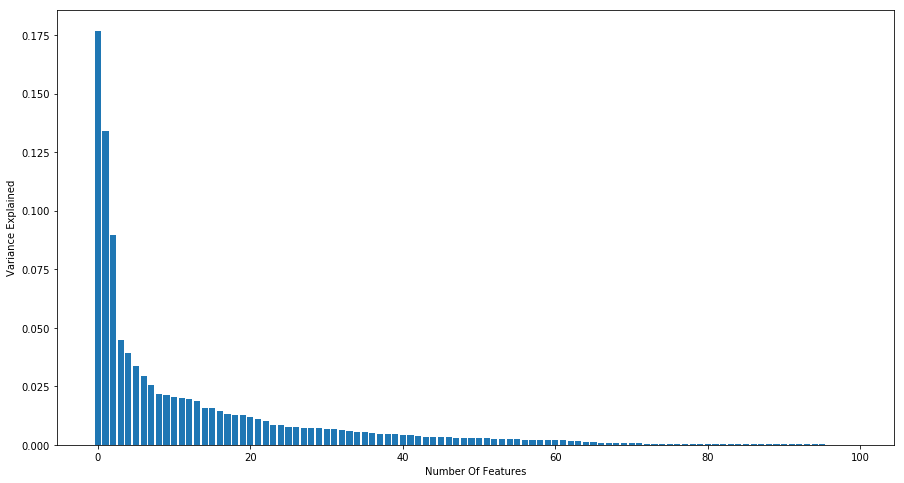

In [117]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(15,8)) 
explained_variance_ratio=[val for val in pca.explained_variance_ratio_]
cv=np.cumsum(np.round(explained_variance_ratio, decimals=3))
plt.ylabel('Variance Explained')
plt.xlabel('Number Of Features')
plt.bar(range(0,len(explained_variance_ratio)),explained_variance_ratio)

In [118]:
print(len(cv))

100


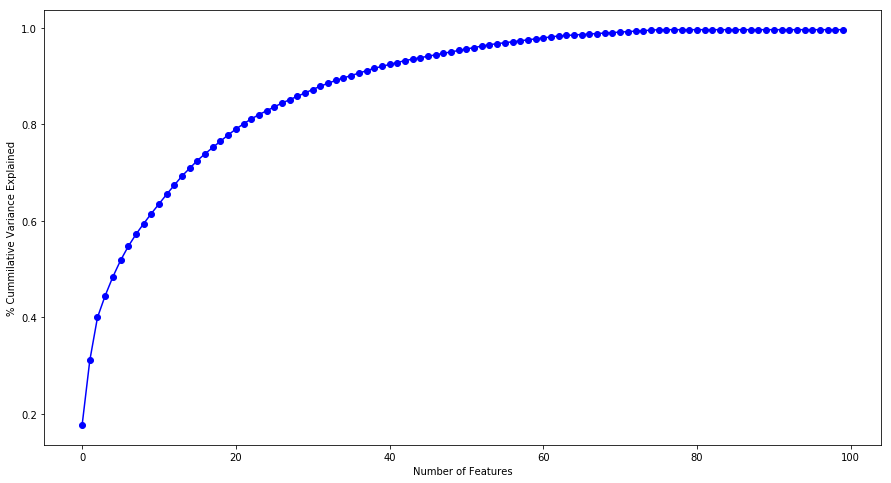

In [119]:
plt.figure(figsize=(15,8)) 
plt.ylabel('% Cummilative Variance Explained')
plt.xlabel('Number of Features')
plt.plot(cv,marker='o', color='b')

In [120]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=20)
azdias_pca = pca.fit_transform(azdias_data)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)   
* I devided the data into parts which were ordinal data and the other.
* I applied an Imputer to replace the missing values of the ordinal data.
* I applied fillna function to replace the missing values of the other data.
* I applied StandardScaler to standardize the ordinal data.
* I used PCA class to apply principal component analysis on the data.
* I chosen 20 componets with the picture of the cummilative variance distribution.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [121]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weightsOfPca(componentIndex):
    components=pca.components_[componentIndex]
    componentspd=pd.DataFrame(components,columns=['weight'])
    componentspd['name']=list(azdias_data.columns)
    print(componentspd.sort_values(by='weight',ascending=False))

In [145]:
weightsOfPca(0)

       weight                   name
101  0.225803             PLZ8_ANTG3
65   0.225796       FINANZ_HAUSBAUER
102  0.211144             PLZ8_ANTG4
82   0.198404     HH_EINKOMMEN_SCORE
108  0.197609              CI_WEALTH
92   0.194100               EWDICHTE
106  0.193496            ORTSGR_KLS9
100  0.175364             PLZ8_ANTG2
89   0.172144            KBA05_ANTG4
88   0.159802            KBA05_ANTG3
107  0.148172               RELAT_AB
105  0.146860                 ARBEIT
112  0.143066    ANZ_HAUSHALTE_AKTIV
79   0.134077             SEMIO_KAEM
77   0.119519             SEMIO_KRIT
78   0.108391              SEMIO_DOM
74   0.091029              SEMIO_ERL
83   0.088973         W_KEIT_KIND_HH
98   0.061466               REGIOTYP
0    0.059201              ANREDE_KZ
113  0.055693           ANZ_HH_TITEL
67   0.054017         RETOURTYP_BK_S
87   0.049339            KBA05_ANTG2
12   0.033596      CAMEO_DEUG_2015_8
103  0.028786               PLZ8_HHZ
95   0.024567                    KKK
7

In [144]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weightsOfPca(1)

       weight                   name
75   0.329088             SEMIO_KULT
69   0.297394              SEMIO_FAM
70   0.283738              SEMIO_REL
72   0.271132             SEMIO_VERT
68   0.216163              SEMIO_SOZ
71   0.211788              SEMIO_MAT
81   0.160147            SEMIO_TRADV
92   0.124284               EWDICHTE
101  0.120399             PLZ8_ANTG3
106  0.114917            ORTSGR_KLS9
102  0.105989             PLZ8_ANTG4
80   0.105133          SEMIO_PFLICHT
100  0.097633             PLZ8_ANTG2
61   0.078844          FINANZ_SPARER
107  0.078744               RELAT_AB
105  0.075353                 ARBEIT
67   0.065880         RETOURTYP_BK_S
64   0.062990  FINANZ_UNAUFFAELLIGER
97   0.056460      ONLINE_AFFINITAET
108  0.041243              CI_WEALTH
88   0.041113            KBA05_ANTG3
89   0.037540            KBA05_ANTG4
110  0.035711           ANZ_PERSONEN
103  0.033093               PLZ8_HHZ
87   0.030429            KBA05_ANTG2
60   0.028447      FINANZ_MINIMALIST
1

In [123]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weightsOfPca(2)

       weight                   name
72   0.369022             SEMIO_VERT
68   0.279255              SEMIO_SOZ
69   0.261762              SEMIO_FAM
75   0.243745             SEMIO_KULT
60   0.174908      FINANZ_MINIMALIST
67   0.117331         RETOURTYP_BK_S
62   0.113672       FINANZ_VORSORGER
83   0.096963         W_KEIT_KIND_HH
59   0.090231   ALTERSKATEGORIE_GROB
73   0.073842             SEMIO_LUST
70   0.067625              SEMIO_REL
71   0.053405              SEMIO_MAT
84   0.038625         WOHNDAUER_2008
102  0.038200             PLZ8_ANTG4
101  0.036872             PLZ8_ANTG3
106  0.036215            ORTSGR_KLS9
92   0.036014               EWDICHTE
105  0.028437                 ARBEIT
107  0.025825               RELAT_AB
89   0.024725            KBA05_ANTG4
100  0.024075             PLZ8_ANTG2
108  0.022443              CI_WEALTH
112  0.022022    ANZ_HAUSHALTE_AKTIV
1    0.018275       GREEN_AVANTGARDE
58   0.018275            PJ_MOVEMENT
113  0.012684           ANZ_HH_TITEL
1

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)
* I gained the weight of components with the attribute of pca.
* I defined the new pandas variable 'componentspd' which contained the weight and name of the compoent.
* I sorted the variable componentspd by weight .

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [124]:
# Over a number of different cluster counts...
results=[]
avgdists=[]
for k in range(2,30):

    # run k-means clustering on the data and...
    kmeans=KMeans(n_clusters=k, random_state=0)
    results.append(kmeans.fit_predict(azdias_pca))
    
    # compute the average within-cluster distances.
    avgdist=-1*(kmeans.score(azdias_pca)/len(azdias_pca))
    avgdists.append(avgdist)
    print(avgdist)
    

38.54532460625099
34.815894124879016
32.307436841452564
30.75362442317988
29.378643652582557
28.154414462856305
27.182487447975568
26.220108360714484
25.59015955608638
25.12290514387901
24.799296897485355
24.3399253362288
23.85711734139412
23.611912819059665
23.27214744584983
22.87480555220148
22.559868936747186
22.334798315012048
22.025745997805128
21.74318850909825
21.500804896987756
21.336422345847357
21.094483347918597
20.888514141825528
20.711107189602146
20.526315827043312
20.369704944218256
20.21063054870108


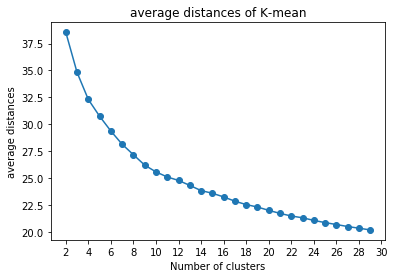

In [125]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(15,8)) 
plt.title('average distances of K-mean')
plt.xlabel('Number of clusters')
plt.ylabel('average distances')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28],[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])
plt.plot(avgdists,marker='o')

In [126]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans=KMeans(n_clusters=10,random_state=0)
result=kmeans.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)
* I tried 30 clusters to draw a average_distance picture and I found the speed of change delicately after 10 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [135]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [136]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_df=clean_data(customers)

customers_ordinal_data=customers_df[ordinal_list]
customers_ordinal_arr=imputer.fit_transform(customers_ordinal_data)
customers_ordinal_arr=scaler.fit_transform(customers_ordinal_arr)
scaled_customers_ordinal=pd.DataFrame(customers_ordinal_arr, columns=list(customers_ordinal_data.columns))

customers_df=customers_df.drop(ordinal_list,axis=1)
customers_df=customers_df.fillna(0)
customers_df=customers_df.merge(scaled_customers_ordinal,left_on=customers_df.index, right_on=scaled_customers_ordinal.index, how='outer')

customers_df=customers_df.drop('key_0',axis=1)
customers_pca = pca.fit_transform(customers_df)

customers_result=kmeans.predict(customers_pca)

c:\program files\python3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\program files\python3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\program files\python3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [137]:
bin_list=np.bincount(result)
print(bin_list)
customers_bin_list=np.bincount(customers_result)
print(customers_bin_list)

[ 93069  88294  61570  80839 121183  91120 126708   3204  64059  57498]
[10266 12388  8474 12827 30835 17939 21604    29 14483  6954]


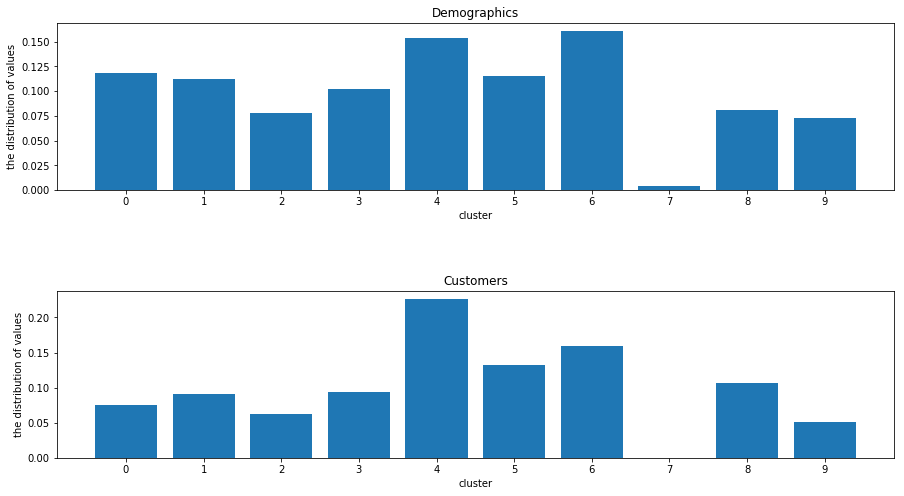

In [138]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


percent_bin_list = list(map(lambda i: i/len(result), bin_list)) 
# print(percent_bin_list)
customers_percent_bin_list = list(map(lambda i: i/len(customers_result), customers_bin_list)) 
plt.figure(figsize=(15,8)) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.6)

ax1=plt.subplot(211)
plt.bar([0,1,2,3,4,5,6,7,8,9],percent_bin_list)
ax1.set_title('Demographics')
ax1.set_xlabel('cluster')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
ax1.set_ylabel('the distribution of values')

ax2=plt.subplot(212)
plt.bar([0,1,2,3,4,5,6,7,8,9],customers_percent_bin_list)
ax2.set_title('Customers')
ax2.set_xlabel('cluster')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
ax2.set_ylabel('the distribution of values')
plt.show()


In [139]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

overrepresented=kmeans.cluster_centers_[0]
print(overrepresented)


[ 1.40667603  1.31172396  2.46573962 -0.14729175  0.20899125 -0.95538893
 -0.17442142  0.17793627 -0.0404586  -0.37069938  0.2726322  -0.03805445
 -0.05343952  0.14777446 -0.228767    0.06759201 -0.05918079  0.01301246
 -0.01664078  0.22040766]


In [140]:
# check the details
l=np.where(customers_result==0)
print(customers_df.iloc[l])

        ANREDE_KZ  GREEN_AVANTGARDE  SOHO_KZ  VERS_TYP  OST_WEST_KZ  \
3               0                 0      0.0       1.0            1   
60              0                 0      0.0       1.0            1   
67              1                 0      0.0       0.0            1   
83              0                 0      0.0       0.0            1   
96              0                 1      0.0       1.0            1   
144             0                 0      0.0       1.0            1   
171             0                 1      0.0       1.0            1   
207             1                 1      0.0       0.0            1   
208             0                 1      0.0       0.0            1   
209             0                 0      0.0       1.0            1   
212             0                 1      0.0       1.0            1   
222             0                 0      0.0       1.0            1   
237             1                 0      0.0       0.0            1   
246   

In [141]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
overrepresented=kmeans.cluster_centers_[2]
print(overrepresented)

[ 4.10774772e+00 -2.93859392e+00  2.34124504e+00 -1.64792155e-01
 -1.14745165e-02 -3.31928990e-02  9.18319290e-02  1.85653345e-01
 -3.55990532e-01  2.47629640e-01 -2.52268698e-02 -1.88441433e-01
 -6.04830995e-02 -1.60525925e-02  1.37101861e-01  2.92764048e-03
  9.05765272e-02  9.99992131e-03  1.20803552e-01 -1.03492160e-01]


In [142]:
# check the details
l=np.where(customers_result==2)
print(customers_df.iloc[l])

        ANREDE_KZ  GREEN_AVANTGARDE  SOHO_KZ  VERS_TYP  OST_WEST_KZ  \
7               1                 0      0.0       1.0            1   
27              1                 0      0.0       0.0            1   
34              1                 1      0.0       0.0            1   
70              1                 1      0.0       1.0            1   
75              1                 0      0.0       0.0            1   
128             1                 0      0.0       1.0            1   
133             1                 1      0.0       1.0            1   
150             1                 0      0.0       0.0            1   
157             1                 0      0.0       0.0            1   
162             1                 1      0.0       0.0            1   
191             1                 1      0.0       0.0            1   
243             1                 1      0.0       0.0            1   
258             1                 1      0.0       0.0            1   
273   

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
* I computed the percentage of all ten clusters of the two datasets which were the demographics data and the customers data.
* I drawed the percentage of the clusters pictures for each data.
* I found the overrepresented cluster 0 and the underrepresented cluster 2.
* 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.